In [1]:
# --- Imports and Data Preparation ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
# Load TSLA data (same as previous notebooks)
TICKER = 'TSLA'
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
tsla_close = data['Close'].ffill().bfill()
tsla_close.columns = ['Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
# --- ARIMA Forecast for Next 12 Months ---
import pmdarima as pm

In [5]:
# Fit ARIMA model on all available data
arima_model = pm.auto_arima(tsla_close['Close'], seasonal=False, stepwise=True, suppress_warnings=True)

c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\d

In [6]:
# Forecast next 252 trading days (~12 months)
n_periods = 252
arima_forecast, arima_conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
future_dates = pd.date_range(tsla_close.index[-1], periods=n_periods+1, freq='B')[1:]

c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1

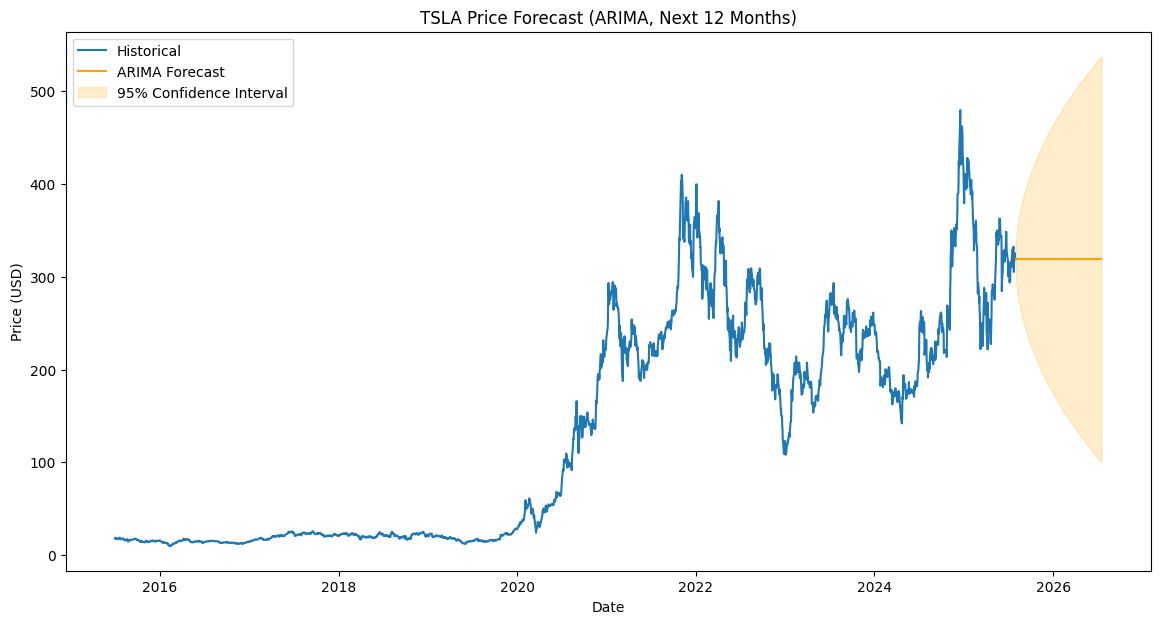

In [7]:
# Plot ARIMA forecast with confidence intervals
plt.figure(figsize=(14,7))
plt.plot(tsla_close.index, tsla_close['Close'], label='Historical')
plt.plot(future_dates, arima_forecast, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int[:,0], arima_conf_int[:,1], color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title('TSLA Price Forecast (ARIMA, Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [8]:
# --- LSTM Forecast for Next 12 Months ---
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Prepare data for LSTM (retrain or load model as needed)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(tsla_close)

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_all, y_all = create_sequences(scaled_close, seq_length)

# Build and train LSTM model (for demonstration; in practice, load your trained model)
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_all, y_all, epochs=10, batch_size=32, verbose=1)

# Forecast future prices
last_window = scaled_close[-seq_length:]
future_lstm_scaled = []
current_input = last_window.copy()

for _ in range(n_periods):
    pred = model.predict(current_input.reshape(1, seq_length, 1), verbose=0)
    future_lstm_scaled.append(pred[0,0])
    current_input = np.roll(current_input, -1)
    current_input[-1] = pred

future_lstm_scaled = np.array(future_lstm_scaled).reshape(-1, 1)
future_lstm = scaler.inverse_transform(future_lstm_scaled)

Epoch 1/10


c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0127
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013


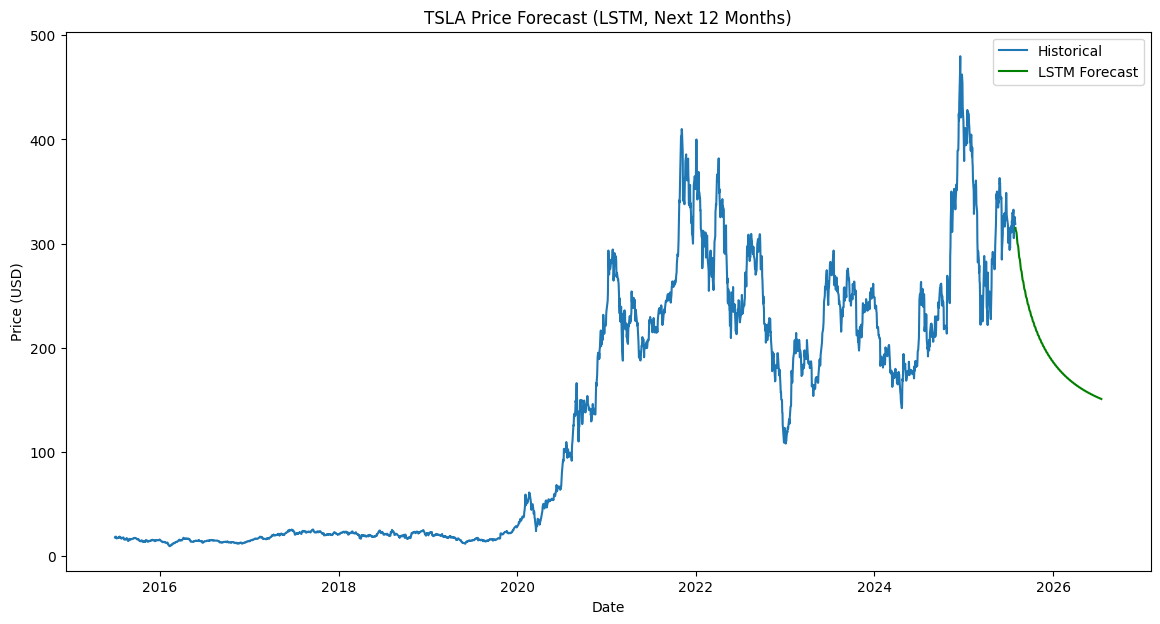

In [10]:
# Plot LSTM forecast
plt.figure(figsize=(14,7))
plt.plot(tsla_close.index, tsla_close['Close'], label='Historical')
plt.plot(future_dates, future_lstm, label='LSTM Forecast', color='green')
plt.title('TSLA Price Forecast (LSTM, Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()